In [1]:
import os
import re
import copy
import numpy
from IPython.display import Image, display
from rmgpy.data.thermo import ThermoLibrary
from rmgpy.data.base import Entry
from rmgpy.data.rmg import RMGDatabase
from rmgpy import settings
from rmgpy.species import Species
from rmgpy.molecule import Molecule
from rmgpy.cantherm.output import prettify

## Variety of helper functions

In [2]:
def addThermoData(thermoData1, thermoData2):
    """
    Add the thermodynamic data `thermoData2` to the data `thermoData1`,
    and return `thermoData1`.
    """
    if len(thermoData1.Tdata.value_si) != len(thermoData2.Tdata.value_si) or any([T1 != T2 for T1, T2 in zip(thermoData1.Tdata.value_si, thermoData2.Tdata.value_si)]):
        raise Exception('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermoData1.Tdata.value_si.shape[0]):
        thermoData1.Cpdata.value_si[i] += thermoData2.Cpdata.value_si[i]
    thermoData1.H298.value_si += thermoData2.H298.value_si
    thermoData1.S298.value_si += thermoData2.S298.value_si

    #if thermoData1.comment:
    #    thermoData1.comment += ' + {0}'.format(thermoData2.comment)
    #else:
    #    thermoData1.comment = 'Thermo group additivity estimation: ' + thermoData2.comment

    return thermoData1

def removeThermoData(thermoData1, thermoData2):
    """
    Remove the thermodynamic data `thermoData2` from the data `thermoData1`,
    and return `thermoData1`.
    """
    if len(thermoData1.Tdata.value_si) != len(thermoData2.Tdata.value_si) or any([T1 != T2 for T1, T2 in zip(thermoData1.Tdata.value_si, thermoData2.Tdata.value_si)]):
        raise Exception('Cannot add these ThermoData objects due to their having different temperature points.')

    for i in range(thermoData1.Tdata.value_si.shape[0]):
        thermoData1.Cpdata.value_si[i] -= thermoData2.Cpdata.value_si[i]
    thermoData1.H298.value_si -= thermoData2.H298.value_si
    thermoData1.S298.value_si -= thermoData2.S298.value_si

    #if thermoData1.comment:
    #    thermoData1.comment += ' + {0}'.format(thermoData2.comment)
    #else:
    #    thermoData1.comment = 'Thermo group additivity estimation: ' + thermoData2.comment

    return thermoData1

def averageThermoData(thermoDataset=[]):
    """
    Average a list of thermoData values together.
    Sets uncertainty values to be the approximately the 95% confidence interval, equivalent to
    2 standard deviations calculated using the sample standard variance:
    
    Uncertainty = 2s
    s = sqrt( sum(abs(x - x.mean())^2) / N - 1) where N is the number of values averaged
    
    Note that uncertainties are only computed when number of values is greater than 1.
    """
    
    numValues = len(thermoDataset)
        
    if numValues == 0:
        raise Exception('No thermo data values were inputted to be averaged.')
    else:
        print 'Averaging thermo data over {0} value(s).'.format(numValues)
        
        if numValues == 1:
            return copy.deepcopy(thermoDataset[0])
        
        else:
            averagedThermoData = copy.deepcopy(thermoDataset[0])
            for thermoData in thermoDataset[1:]:
                averagedThermoData = addThermoData(averagedThermoData, thermoData)


            for i in range(averagedThermoData.Tdata.value_si.shape[0]):
                averagedThermoData.Cpdata.value_si[i] /= numValues
                #print averagedThermoData.Cpdata.uncertainty
                cpData = [thermoData.Cpdata.value_si[i] for thermoData in thermoDataset]
                averagedThermoData.Cpdata.uncertainty[i] = 2*numpy.std(cpData, ddof=1)

            HData = [thermoData.H298.value_si for thermoData in thermoDataset]
            averagedThermoData.H298.value_si /= numValues
            averagedThermoData.H298.uncertainty_si = 2*numpy.std(HData, ddof=1)

            SData = [thermoData.S298.value_si for thermoData in thermoDataset]
            averagedThermoData.S298.value_si /= numValues
            averagedThermoData.S298.uncertainty_si = 2*numpy.std(SData, ddof=1)
            return averagedThermoData
        
def extractPolycyclicGroups(molecule):
    """
    Extract polycyclic functional groups from a real molecule
    """
    struct = molecule.copy(deep=True)
    # Saturate the structure if it is a radical
    if struct.isRadical():
        struct.saturate()
    struct.deleteHydrogens()
    
    polyRings = struct.getPolycyclicRings()
    groups = [convertCycleToGroup(ring) for ring in polyRings]
    
    return groups
                
def convertCycleToGroup(cycle):
    """
    This function converts a list of atoms in a cycle to a functional Group object
    """
    from rmgpy.molecule.group import GroupAtom, GroupBond, Group
    
    # Create GroupAtom object for each atom in the cycle, label the first one in the cycle with a *
    groupAtoms = {}
    bonds = []
    for atom in cycle:
        groupAtoms[atom] = GroupAtom(atomType=[atom.atomType],
                                     radicalElectrons=[0],
                                     label='*' if cycle.index(atom)==0 else '')
                
    group = Group(atoms=groupAtoms.values())            
    
    # Create GroupBond for each bond between atoms in the cycle, but not outside of the cycle
    for atom in cycle:
        for bondedAtom, bond in atom.edges.iteritems():
            if bondedAtom in cycle:
                # create a group bond with the same bond order as in the original molecule,
                # if it hasn't already been created
                if not group.hasBond(groupAtoms[atom],groupAtoms[bondedAtom]):
                    group.addBond(GroupBond(groupAtoms[atom],groupAtoms[bondedAtom],order=[bond.order]))
            else:
                pass
        
    group.update()
    
    return group

def returnPolycyclicGroupStrings(thermoComment):
    """
    Takes a string of comments from group additivity estimation, and extracts the polycyclic group strings out of them
    """
    tokens = thermoComment.split()
    polycyclicGroups = []
    for token in tokens:
        if 'polycyclic' in token:
            splitTokens = re.split("\(|\)",token)
            assert len(splitTokens) == 3
            groupLabel = splitTokens[1]
            polycyclicGroups.append(groupLabel)
    return polycyclicGroups

## Thermo comparison and display functions

In [3]:
def displayThermo(thermoData):
    print 'H298 = {0} kcal/mol'.format(thermoData.H298.value_si/4184)
    print 'S298 = {0} cal/mol*K'.format(thermoData.S298.value_si/4.184)
def compareThermoData(thermoData1, thermoData2):
    delH = thermoData1.H298.value_si - thermoData2.H298.value_si
    print 'Difference in H298 = {0} kcal/mol'.format(delH/4184)
    delS = thermoData1.S298.value_si - thermoData2.S298.value_si
    print 'Difference S298 = {0} cal/mol*K'.format(delS/4.184)
    #Tdata = [300,500,1000,2000]
    #for T in Tdata:
    #    delCp = thermoData1.getHeatCapacity(T) - thermoData2.getHeatCapacity(T)
    #    print 'Difference in Cp at {0} = {1} cal/mol*K'.format(T, delCp/4.184)

## Load all the thermo libraries

In [4]:
# Fill in the list of thermo libraries to be used for fitting polycyclic thermo groups
thermoLibraries = ['vinylCPD_H','C3','C10H11','Fulvene_H','naphthalene_H']
database = RMGDatabase()
database.load(settings['database.directory'], thermoLibraries = thermoLibraries, kineticsFamilies='none', kineticsDepositories='none', reactionLibraries=[])

thermoDatabase = database.thermo
thermoDatabase0 = copy.deepcopy(database.thermo)

## Extract polycyclic groups from thermo libraries and create new ones

product1
Species has 1 resonance isomers
Molecule CC1C2[CH]C=CC12 has a single polycyclic group match in thermo estimate.


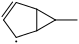

Molecule SMILES: CC1C2[CH]C=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([131.085, 170.916, 204.765, 231.166, 271.416, 298.319, 338.695], 'J/(mol*K)'),
    H298 = (113.541, 'kJ/mol'),
    S298 = (59.9435, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 27.137 kcal/mol
S298 = 14.3268305179 cal/mol*K
1 * Cd u0 {2,D} {5,S}
2   Cd u0 {1,D} {4,S}
3   Cs u0 {4,S} {5,S} {6,S}
4   Cs u0 {2,S} {3,S} {6,S}
5   Cs u0 {1,S} {3,S}
6   Cs u0 {3,S} {4,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product1.
product3
Species has 1 resonance isomers
Molecule [CH]1C=CC2CCC12 has a single polycyc

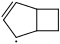

Molecule SMILES: [CH]1C=CC2CCC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([132.214, 171.167, 204.472, 230.58, 270.621, 297.733, 337.649], 'J/(mol*K)'),
    H298 = (122.913, 'kJ/mol'),
    S298 = (71.1698, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 29.377 kcal/mol
S298 = 17.01 cal/mol*K
1 * Cs u0 {5,S} {7,S}
2   Cs u0 {4,S} {5,S} {7,S}
3   Cd u0 {4,S} {6,D}
4   Cs u0 {2,S} {3,S}
5   Cs u0 {1,S} {2,S}
6   Cd u0 {3,D} {7,S}
7   Cs u0 {1,S} {2,S} {6,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product3.
product6
Species has 1 resonance isomers
Molecule [CH]1CC2C=CC1C2 has a s

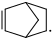

Molecule SMILES: [CH]1CC2C=CC1C2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([97.6964, 138.482, 173.423, 203.096, 247.274, 276.445, 321.089], 'J/(mol*K)'),
    H298 = (266.006, 'kJ/mol'),
    S298 = (330.578, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(norbornene) + radical(Cs_S)',
)
H298 = 63.577 kcal/mol
S298 = 79.01 cal/mol*K
Matched polycyclic group "norbornene"
product8
Species has 1 resonance isomers
Molecule [CH]1CC2CC=CC12 has a single polycyclic group match in thermo estimate.


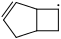

Molecule SMILES: [CH]1CC2CC=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([133.219, 168.908, 200.539, 225.894, 265.475, 292.629, 332.879], 'J/(mol*K)'),
    H298 = (184, 'kJ/mol'),
    S298 = (105.981, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product3) + radical(cyclobutane)',
)
H298 = 43.977 kcal/mol
S298 = 25.33 cal/mol*K
Matched polycyclic group "product3"
product17
Species has 1 resonance isomers
Molecule [CH]1C2C=CC1CC2 has a single polycyclic group match in thermo estimate.


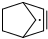

Molecule SMILES: [CH]1C2C=CC1CC2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([98.5332, 138.357, 173.757, 202.886, 246.312, 276.822, 321.967], 'J/(mol*K)'),
    H298 = (258.684, 'kJ/mol'),
    S298 = (330.871, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(norbornene) + radical(cyclopentene-4)',
)
H298 = 61.827 kcal/mol
S298 = 79.08 cal/mol*K
Matched polycyclic group "norbornene"
product19
Species has 2 resonance isomers
Molecule CC12[CH]C=CC1C2 has a single polycyclic group match in thermo estimate.


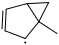

Molecule SMILES: CC12[CH]C=CC1C2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([134.39, 175.435, 210.079, 236.898, 276.521, 302.503, 338.82], 'J/(mol*K)'),
    H298 = (110.905, 'kJ/mol'),
    S298 = (53.5001, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsCs) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product1) + radical(cyclopentene-allyl)',
)
H298 = 26.507 kcal/mol
S298 = 12.7868305179 cal/mol*K
Matched polycyclic group "product1"
Molecule CC12C=C[CH]C1C2 has a single polycyclic group match in thermo estimate.


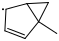

Molecule SMILES: CC12C=C[CH]C1C2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([134.39, 175.435, 209.66, 236.898, 276.521, 302.754, 338.82], 'J/(mol*K)'),
    H298 = (114.085, 'kJ/mol'),
    S298 = (53.5001, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsCs) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product1) + radical(cyclopentene-allyl)',
)
H298 = 27.267 kcal/mol
S298 = 12.7868305179 cal/mol*K
Matched polycyclic group "product1"
product23
Species has 2 resonance isomers
Molecule C1=CC2CC[C]1C2 has a single polycyclic group match in thermo estimate.


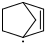

Molecule SMILES: C1=CC2CC[C]1C2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([96.483, 138.273, 174.929, 204.853, 249.241, 280.211, 327.992], 'J/(mol*K)'),
    H298 = (203.037, 'kJ/mol'),
    S298 = (296.562, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(norbornene) + radical(Allyl_T)',
)
H298 = 48.527 kcal/mol
S298 = 70.88 cal/mol*K
Matched polycyclic group "norbornene"
Molecule [CH]1C=C2CCC1C2 has a single polycyclic group match in thermo estimate.


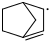

Molecule SMILES: [CH]1C=C2CCC1C2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([134.39, 173.008, 205.434, 231.417, 270.872, 297.984, 337.356], 'J/(mol*K)'),
    H298 = (117.223, 'kJ/mol'),
    S298 = (76.1906, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 28.017 kcal/mol
S298 = 18.21 cal/mol*K
1 * Cd u0 {3,S} {4,S} {6,D}
2   Cs u0 {3,S} {5,S} {7,S}
3   Cs u0 {1,S} {2,S}
4   Cs u0 {1,S} {5,S}
5   Cs u0 {2,S} {4,S}
6   Cd u0 {1,D} {7,S}
7   Cs u0 {2,S} {6,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product23.
product25
Species has 2 resonance isomers
Molecule C1=C[C]2CCC2C1

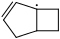

Molecule SMILES: C1=C[C]2CCC2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([131.168, 168.824, 201.711, 227.861, 268.404, 296.018, 338.904], 'J/(mol*K)'),
    H298 = (127.516, 'kJ/mol'),
    S298 = (71.6719, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product3) + radical(Allyl_T)',
)
H298 = 30.477 kcal/mol
S298 = 17.13 cal/mol*K
Matched polycyclic group "product3"
Molecule [CH]1C=C2CCC2C1 has a single polycyclic group match in thermo estimate.


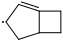

Molecule SMILES: [CH]1C=C2CCC2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([134.39, 173.008, 205.853, 231.417, 270.872, 297.984, 337.356], 'J/(mol*K)'),
    H298 = (118.269, 'kJ/mol'),
    S298 = (76.1906, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 28.267 kcal/mol
S298 = 18.21 cal/mol*K
1 * Cd u0 {4,S} {6,D} {7,S}
2   Cs u0 {3,S} {4,S}
3   Cs u0 {2,S} {6,S}
4   Cs u0 {1,S} {2,S} {5,S}
5   Cs u0 {4,S} {7,S}
6   Cd u0 {1,D} {3,S}
7   Cs u0 {1,S} {5,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product25.
product29
Species has 2 resonance isomers
Molecule [CH]1C2=CCC1CC

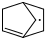

Molecule SMILES: [CH]1C2=CCC1CC2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([134.39, 173.008, 205.434, 231.417, 270.872, 297.984, 337.356], 'J/(mol*K)'),
    H298 = (117.223, 'kJ/mol'),
    S298 = (76.1906, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product23) + radical(cyclopentene-allyl)',
)
H298 = 28.017 kcal/mol
S298 = 18.21 cal/mol*K
Matched polycyclic group "product23"
Molecule [CH]1CC2C=C1CC2 has a single polycyclic group match in thermo estimate.


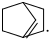

Molecule SMILES: [CH]1CC2C=C1CC2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([134.39, 173.008, 205.853, 231.417, 270.872, 297.984, 337.356], 'J/(mol*K)'),
    H298 = (118.269, 'kJ/mol'),
    S298 = (76.1906, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 28.267 kcal/mol
S298 = 18.21 cal/mol*K
1 * Cd u0 {3,S} {5,D} {7,S}
2   Cs u0 {6,S} {7,S}
3   Cs u0 {1,S} {4,S}
4   Cs u0 {3,S} {6,S}
5   Cd u0 {1,D} {6,S}
6   Cs u0 {2,S} {4,S} {5,S}
7   Cs u0 {1,S} {2,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product29.
product34
Species has 1 resonance isomers
Molecule [CH]1C2C=CC=CC

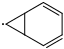

Molecule SMILES: [CH]1C2C=CC=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([124.516, 159.201, 188.406, 209.744, 242.714, 264.596, 297.148], 'J/(mol*K)'),
    H298 = (321.109, 'kJ/mol'),
    S298 = (80.542, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopropane)',
)
H298 = 76.747 kcal/mol
S298 = 19.25 cal/mol*K
1 * Cs u0 {3,S} {6,S} {7,S}
2   Cd u0 {3,D} {5,S}
3   Cd u0 {1,S} {2,D}
4   Cd u0 {5,D} {7,S}
5   Cd u0 {2,S} {4,D}
6   Cs u0 {1,S} {7,S}
7   Cs u0 {1,S} {4,S} {6,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product34.
product36
Species has 2 resonance isomers
Molecule C=C1[CH]C2

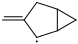

Molecule SMILES: C=C1[CH]C2CC2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([135.896, 174.975, 207.736, 233.76, 273.006, 299.616, 338.946], 'J/(mol*K)'),
    H298 = (133.248, 'kJ/mol'),
    S298 = (61.0972, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsHH) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 31.847 kcal/mol
S298 = 14.6025734167 cal/mol*K
1 * Cs u0 {3,S} {6,S}
2   Cs u0 {5,S} {6,S}
3   Cd u0 {1,S} {4,S}
4   Cs u0 {3,S} {5,S}
5   Cs u0 {2,S} {4,S} {6,S}
6   Cs u0 {1,S} {2,S} {5,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product36.
Molecule [CH2]C1=CC2CC2C1 has a single polycyclic group match in thermo estimate.


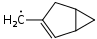

Molecule SMILES: [CH2]C1=CC2CC2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([138.7, 178.406, 211.292, 236.438, 274.847, 300.83, 339.448], 'J/(mol*K)'),
    H298 = (132.871, 'kJ/mol'),
    S298 = (71.9756, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)HHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product1) + radical(Allyl_P)',
)
H298 = 31.757 kcal/mol
S298 = 17.2025734167 cal/mol*K
Matched polycyclic group "product1"
product39
Species has 1 resonance isomers
Molecule [CH2]C12C=CCC1C2 has a single polycyclic group match in thermo estimate.


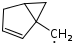

Molecule SMILES: [CH2]C12C=CCC1C2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([138.365, 177.527, 209.786, 235.517, 273.383, 298.905, 334.553], 'J/(mol*K)'),
    H298 = (192.744, 'kJ/mol'),
    S298 = (85.4899, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsCs) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product1) + radical(Neopentyl)',
)
H298 = 46.067 kcal/mol
S298 = 20.4325734167 cal/mol*K
Matched polycyclic group "product1"
product42
Species has 1 resonance isomers
Molecule C=C1C2[CH]C=CC12 has a single polycyclic group match in thermo estimate.


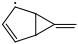

Molecule SMILES: C=C1C2[CH]C=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([127.779, 161.168, 189.828, 211.71, 244.973, 267.609, 300.495], 'J/(mol*K)'),
    H298 = (236.969, 'kJ/mol'),
    S298 = (44.9469, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsHH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 56.637 kcal/mol
S298 = 10.7425734167 cal/mol*K
1 * Cd u0 {5,S} {6,S}
2   Cd u0 {3,S} {4,D}
3   Cs u0 {2,S} {5,S}
4   Cd u0 {2,D} {6,S}
5   Cs u0 {1,S} {3,S} {6,S}
6   Cs u0 {1,S} {4,S} {5,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product42.
product45
Species has 1 resonance isomers
Molecule [CH]1C=CC2C=CC12 h

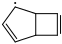

Molecule SMILES: [CH]1C=CC2C=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([124.097, 157.36, 186.146, 208.531, 242.588, 265.726, 299.198], 'J/(mol*K)'),
    H298 = (239.396, 'kJ/mol'),
    S298 = (55.0196, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 57.217 kcal/mol
S298 = 13.15 cal/mol*K
1 * Cd u0 {2,S} {5,D}
2   Cs u0 {1,S} {4,S} {7,S}
3   Cd u0 {4,S} {6,D}
4   Cs u0 {2,S} {3,S} {5,S}
5   Cd u0 {1,D} {4,S}
6   Cd u0 {3,D} {7,S}
7   Cs u0 {2,S} {6,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product45.
product46
Species has 3 resonance isomers
Molecule [CH]

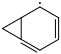

Molecule SMILES: [CH]1C=CC=C2CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([125.687, 163.302, 193.301, 215.267, 248.111, 269.952, 301.625], 'J/(mol*K)'),
    H298 = (230.066, 'kJ/mol'),
    S298 = (50.7519, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 54.987 kcal/mol
S298 = 12.13 cal/mol*K
1 * Cd u0 {3,D} {6,S} {7,S}
2   Cd u0 {3,S} {5,D}
3   Cd u0 {1,D} {2,S}
4   Cs u0 {5,S} {6,S}
5   Cd u0 {2,D} {4,S}
6   Cs u0 {1,S} {4,S} {7,S}
7   Cs u0 {1,S} {6,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product46.
Molecule [CH]1C=CC2CC2=C1 has a single polycyclic group ma

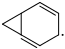

Molecule SMILES: [CH]1C=CC2CC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([123.637, 158.741, 187.987, 211.041, 244.848, 268.153, 303.842], 'J/(mol*K)'),
    H298 = (208.602, 'kJ/mol'),
    S298 = (59.1199, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 49.857 kcal/mol
S298 = 14.13 cal/mol*K
1 * Cd u0 {3,S} {4,D} {6,S}
2   Cd u0 {3,S} {7,D}
3   Cs u0 {1,S} {2,S} {6,S}
4   Cd u0 {1,D} {5,S}
5   Cs u0 {4,S} {7,S}
6   Cs u0 {1,S} {3,S}
7   Cd u0 {2,D} {5,S}

Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: product46-1.
Molecule C1C=CC2C[C]2C=1 has a single polycyclic group 

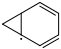

Molecule SMILES: C1C=CC2C[C]2C=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([122.466, 159.118, 189.577, 211.71, 245.643, 267.985, 303.173], 'J/(mol*K)'),
    H298 = (226.551, 'kJ/mol'),
    S298 = (46.2332, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(product34) + radical(Allyl_T)',
)
H298 = 54.147 kcal/mol
S298 = 11.05 cal/mol*K
Matched polycyclic group "product34"
pdt7
Species has 2 resonance isomers
Molecule [CH]1C=CC2C1C1CC=CC21 has a single polycyclic group match in thermo estimate.


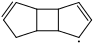

Molecule SMILES: [CH]1C=CC2C1C1CC=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.824, 233.635, 279.575, 314.386, 367.481, 402.082, 452.918], 'J/(mol*K)'),
    H298 = (201.991, 'kJ/mol'),
    S298 = (0.6276, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product3) + radical(cyclopentene-allyl)',
)
H298 = 48.277 kcal/mol
S298 = 0.15 cal/mol*K
Matched polycyclic group "product3"
Molecule [CH]1C=CC2C1C1C=CCC21 has a single polycyclic group match in thermo estimate.


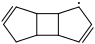

Molecule SMILES: [CH]1C=CC2C1C1C=CCC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.824, 233.635, 279.575, 314.386, 367.481, 402.082, 452.918], 'J/(mol*K)'),
    H298 = (201.991, 'kJ/mol'),
    S298 = (0.6276, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product3) + radical(cyclopentene-allyl)',
)
H298 = 48.277 kcal/mol
S298 = 0.15 cal/mol*K
Matched polycyclic group "product3"
pdt8
Species has 3 resonance isomers
Molecule [CH]1C=CC=CC2CC=CC12 has a single polycyclic group match in thermo estimate.


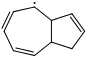

Molecule SMILES: [CH]1C=CC=CC2CC=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.155, 231.877, 276.06, 309.114, 359.447, 393.212, 442.96], 'J/(mol*K)'),
    H298 = (288.432, 'kJ/mol'),
    S298 = (155.017, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 68.937 kcal/mol
S298 = 37.05 cal/mol*K
1  * Cs u0 {2,S} {4,S} {7,S}
2    Cd u0 {1,S} {10,D}
3    Cd u0 {8,D} {9,S}
4    Cs u0 {1,S} {6,S}
5    Cs u0 {7,S} {10,S}
6    Cd u0 {4,S} {9,D}
7    Cs u0 {1,S} {5,S} {8,S}
8    Cd u0 {3,D} {7,S}
9    Cd u0 {3,S}

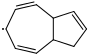

Molecule SMILES: [CH]1C=CC2C=CCC2C=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([176.105, 227.317, 270.747, 304.888, 356.184, 391.413, 445.178], 'J/(mol*K)'),
    H298 = (266.968, 'kJ/mol'),
    S298 = (163.385, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 63.807 kcal/mol
S298 = 39.05 cal/mol*K
1  * Cs u0 {8,S} {10,S}
2    Cd u0 {5,D} {9,S}
3    Cs u0 {4,S} {7,S} {8,S}
4    Cd u0 {3,S} {10,D}
5    Cd u0 {2,D} {8,S}
6    Cd u0 {7,D} {9,S}
7    Cd u0 {3,S} {6,D}
8    Cs u0 {1,S} {3,S} {5,S}
9    Cs u0 {2

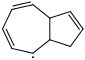

Molecule SMILES: [CH]1C=CC=CC2C=CCC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.431, 234.89, 276.73, 309.742, 358.778, 392.585, 442.332], 'J/(mol*K)'),
    H298 = (288.265, 'kJ/mol'),
    S298 = (147.821, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 68.897 kcal/mol
S298 = 35.33 cal/mol*K
1    Cs u0 {2,S} {3,S} {6,S}
2  * Cs u0 {1,S} {4,S} {5,S}
3    Cd u0 {1,S} {9,D}
4    Cs u0 {2,S} {10,S}
5    Cs u0 {2,S} {9,S}
6    Cd u0 {1,S} {7,D}
7    Cd u0 {6,D} {8,S}
8    Cd u0 {7,S} {10,D}
9    Cd u0 {3,D}

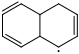

Molecule SMILES: [CH]1C=CCC2C=CC=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.155, 231.877, 276.06, 309.114, 359.447, 393.212, 442.96], 'J/(mol*K)'),
    H298 = (285.922, 'kJ/mol'),
    S298 = (155.017, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 68.337 kcal/mol
S298 = 37.05 cal/mol*K
1  * Cs u0 {4,S} {7,S} {10,S}
2    Cs u0 {3,S} {4,S}
3    Cd u0 {2,S} {5,D}
4    Cs u0 {1,S} {2,S} {8,S}
5    Cd u0 {3,D} {7,S}
6    Cd u0 {9,S} {10,D}
7    Cs u0 {1,S} {5,S}
8    Cd u0 {4,S} {9,D}
9    C

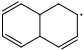

Molecule SMILES: [CH]1C=CC2C=CC=CC2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.431, 234.89, 277.148, 309.742, 358.778, 392.585, 442.332], 'J/(mol*K)'),
    H298 = (286.801, 'kJ/mol'),
    S298 = (147.821, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 68.547 kcal/mol
S298 = 35.33 cal/mol*K
1  * Cs u0 {2,S} {3,S} {4,S}
2    Cs u0 {1,S} {8,S}
3    Cs u0 {1,S} {6,S} {9,S}
4    Cd u0 {1,S} {10,D}
5    Cd u0 {8,S} {9,D}
6    Cd u0 {3,S} {7,D}
7    Cd u0 {6,D} {10,S}
8    Cs u0 {2,S} {5,S}
9    

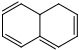

Molecule SMILES: C1=CCC2C=CC=CC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([190.037, 241.752, 281.541, 310.662, 352.376, 381.288, 424.509], 'J/(mol*K)'),
    H298 = (226.354, 'kJ/mol'),
    S298 = (125.562, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 54.1 kcal/mol
S298 = 30.01 cal/mol*K
1    Cd u0 {5,D} {8,S}
2    Cd u0 {6,D} {7,S}
3    Cs u0 {4,S} {6,S} {10,S}
4    Cd u0 {3,S} {8,D} {9,S}
5  * Cd u0 {1,D} {10,S}
6    Cd u0 {2,D} {3,S}
7    Cd u0 {2,S} {9,D}
8    Cd u0 {1,S} {4,D}
9    Cd u0 {4,

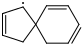

Molecule SMILES: [CH]1C=CCC12C=CC=CC2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([181.46, 236.396, 280.537, 314.846, 364.552, 397.647, 443.086], 'J/(mol*K)'),
    H298 = (274.123, 'kJ/mol'),
    S298 = (148.574, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsCs) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 65.517 kcal/mol
S298 = 35.51 cal/mol*K
1  * Cs u0 {6,S} {9,S}
2    Cd u0 {4,S} {10,D}
3    Cs u0 {8,S} {9,S}
4    Cd u0 {2,S} {8,D}
5    Cd u0 {6,D} {7,S}
6    Cd u0 {1,S} {5,D}
7    Cs u0 {5,S} {9,S}
8    Cd u0 {3,S} {4,D}
9    Cs u0 {1,S} 

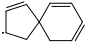

Molecule SMILES: [CH]1C=CC2(C=CC=CC2)C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([183.05, 236.773, 280.244, 314.26, 363.924, 397.062, 442.625], 'J/(mol*K)'),
    H298 = (273.412, 'kJ/mol'),
    S298 = (146.984, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsCs) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 65.347 kcal/mol
S298 = 35.13 cal/mol*K
1  * Cd u0 {7,S} {9,D}
2    Cs u0 {3,S} {5,S}
3    Cs u0 {2,S} {8,S} {9,S} {10,S}
4    Cd u0 {6,S} {8,D}
5    Cd u0 {2,S} {6,D}
6    Cd u0 {4,S} {5,D}
7    Cs u0 {1,S} {10,S}
8    Cd u0 {3,S} {4,D}
9  

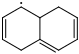

Molecule SMILES: [CH]1C=CCC2=CC=CCC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([180.163, 233.844, 277.064, 309.825, 359.406, 393.38, 442.374], 'J/(mol*K)'),
    H298 = (281.487, 'kJ/mol'),
    S298 = (160.122, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 67.277 kcal/mol
S298 = 38.27 cal/mol*K
1  * Cd u0 {2,S} {9,D}
2    Cd u0 {1,S} {5,D}
3    Cd u0 {7,S} {10,D}
4    Cs u0 {5,S} {6,S}
5    Cd u0 {2,D} {4,S}
6    Cs u0 {4,S} {8,S} {9,S}
7    Cs u0 {3,S} {9,S}
8    Cs u0 {6,S} {10,S}
9   

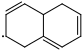

Molecule SMILES: [CH]1C=CC2CC=CC=C2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([186.606, 236.731, 278.11, 310.578, 359.029, 392.836, 442.04], 'J/(mol*K)'),
    H298 = (281.11, 'kJ/mol'),
    S298 = (152.842, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 67.187 kcal/mol
S298 = 36.53 cal/mol*K
1  * Cd u0 {6,D} {10,S}
2    Cs u0 {7,S} {10,S}
3    Cd u0 {5,D} {8,S}
4    Cs u0 {6,S} {7,S} {9,S}
5    Cd u0 {3,D} {9,S}
6    Cd u0 {1,D} {4,S}
7    Cd u0 {2,S} {4,S} {8,D}
8    Cd u0 {3,S} {7,D}


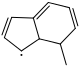

Molecule SMILES: CC1C=CC=C2C=C[CH]C21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.891, 240.58, 285.014, 317.064, 365.096, 397.396, 445.805], 'J/(mol*K)'),
    H298 = (245.505, 'kJ/mol'),
    S298 = (131.03, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 58.677 kcal/mol
S298 = 31.3168305179 cal/mol*K
1 * Cd u0 {8,S} {9,D}
2   Cd u0 {3,D} {4,S}
3   Cd u0 {2,D} {7,S}
4   Cd u0 {2,S} {6,D}
5   Cs u0 {6,S} {7,S} {8,S}
6   Cd u0 {4,D} {5,S} {9,S}
7   Cs u0 {3,S} {5,S}
8   Cs u0 {1,S} {5,S}


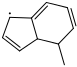

Molecule SMILES: CC1C=CC=C2[CH]C=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.841, 236.019, 279.7, 312.838, 361.832, 395.597, 448.023], 'J/(mol*K)'),
    H298 = (236.383, 'kJ/mol'),
    S298 = (140.695, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 56.497 kcal/mol
S298 = 33.6268305179 cal/mol*K
1 * Cs u0 {4,S} {6,S}
2   Cs u0 {5,S} {9,S}
3   Cd u0 {4,D} {9,S}
4   Cd u0 {1,S} {3,D}
5   Cd u0 {2,S} {8,D}
6   Cd u0 {1,S} {7,D} {9,S}
7   Cd u0 {6,D} {8,S}
8   Cd u0 {5,D} {7,S}
9   Cs u0 {2,S} 

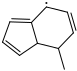

Molecule SMILES: CC1C=C[CH]C2=CC=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.841, 236.019, 279.7, 312.838, 361.832, 395.597, 448.023], 'J/(mol*K)'),
    H298 = (236.383, 'kJ/mol'),
    S298 = (140.695, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 56.497 kcal/mol
S298 = 33.6268305179 cal/mol*K
1 * Cd u0 {7,D} {8,S}
2   Cs u0 {4,S} {5,S}
3   Cd u0 {4,D} {9,S}
4   Cd u0 {2,S} {3,D}
5   Cs u0 {2,S} {6,S} {7,S}
6   Cd u0 {5,S} {8,D} {9,S}
7   Cd u0 {1,D} {5,S}
8   Cd u0 {1,S} {6,D}
9   Cs u0 

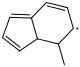

Molecule SMILES: CC1[CH]C=CC2=CC=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([191.167, 243.592, 285.684, 317.691, 364.426, 396.769, 445.178], 'J/(mol*K)'),
    H298 = (256.634, 'kJ/mol'),
    S298 = (123.833, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclohexene-allyl)',
)
H298 = 61.337 kcal/mol
S298 = 29.5968305179 cal/mol*K
1 * Cs u0 {3,S} {6,S}
2   Cs u0 {3,S} {4,S} {7,S}
3   Cs u0 {1,S} {2,S}
4   Cd u0 {2,S} {5,D} {8,S}
5   Cd u0 {4,D} {9,S}
6   Cd u0 {1,S} {8,D}
7   Cd u0 {2,S} {9,D}
8   Cd u0 {4,S} {6,D}

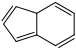

Molecule SMILES: C1C=CC2C=CC=C2C=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([165.394, 210.623, 244.471, 268.864, 303.8, 327.9, 364.385], 'J/(mol*K)'),
    H298 = (252.588, 'kJ/mol'),
    S298 = (89.6213, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 60.37 kcal/mol
S298 = 21.42 cal/mol*K
1 * Cd u0 {3,D} {7,S}
2   Cd u0 {5,S} {6,S} {8,D}
3   Cd u0 {1,D} {5,S}
4   Cd u0 {8,S} {9,D}
5   Cs u0 {2,S} {3,S} {9,S}
6   Cd u0 {2,S} {7,D}
7   Cd u0 {1,S} {6,D}
8   Cd u0 {2,D} {4,S}
9   Cd u0 {4,D} {5,S}

Polycyclic group was found to be ge

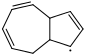

Molecule SMILES: [CH]1C=CC2C=CC=CCC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.431, 234.89, 276.73, 309.742, 358.778, 392.585, 442.332], 'J/(mol*K)'),
    H298 = (274.458, 'kJ/mol'),
    S298 = (147.821, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(pdt8-2) + radical(cyclopentene-allyl)',
)
H298 = 65.597 kcal/mol
S298 = 35.33 cal/mol*K
Matched polycyclic group "pdt8-2"
Molecule [CH]1C=CC2CC=CC=CC12 has a single polycyclic group match in thermo estimate.


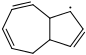

Molecule SMILES: [CH]1C=CC2CC=CC=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.155, 231.877, 276.06, 309.114, 359.447, 393.212, 442.96], 'J/(mol*K)'),
    H298 = (274.625, 'kJ/mol'),
    S298 = (155.017, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(pdt8) + radical(cyclopentene-allyl)',
)
H298 = 65.637 kcal/mol
S298 = 37.05 cal/mol*K
Matched polycyclic group "pdt8"
pdt24
Species has 2 resonance isomers
Molecule [CH]1C=CCC23CC=CC2C13 has a single polycyclic group match in thermo estimate.


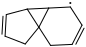

Molecule SMILES: [CH]1C=CCC23CC=CC2C13
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.13, 238.153, 284.47, 320.118, 372.585, 406.266, 453.044], 'J/(mol*K)'),
    H298 = (209.606, 'kJ/mol'),
    S298 = (-5.81576, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsCs) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product1) + radical(cyclohexene-allyl)',
)
H298 = 50.097 kcal/mol
S298 = -1.39 cal/mol*K
Matched polycyclic group "product1"
Molecule [CH]1C=CC2C3C=CCC23C1 has a single polycyclic group match in thermo estimate.


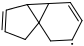

Molecule SMILES: [CH]1C=CC2C3C=CCC23C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.13, 238.153, 284.889, 320.118, 372.585, 406.266, 453.044], 'J/(mol*K)'),
    H298 = (210.652, 'kJ/mol'),
    S298 = (-5.81576, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsCs) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product1) + radical(cyclohexene-allyl)',
)
H298 = 50.347 kcal/mol
S298 = -1.39 cal/mol*K
Matched polycyclic group "product1"
pdt26
Species has 1 resonance isomers
Molecule C1=CCC2=CC=CCC2=C1 has a single polycyclic group match in thermo estimate.


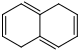

Molecule SMILES: C1=CCC2=CC=CCC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([185.602, 240.831, 281.5, 310.62, 352.711, 381.999, 424.258], 'J/(mol*K)'),
    H298 = (223.76, 'kJ/mol'),
    S298 = (136.649, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 53.48 kcal/mol
S298 = 32.66 cal/mol*K
1  * Cd u0 {4,D} {7,S}
2    Cs u0 {6,S} {9,S}
3    Cs u0 {4,S} {8,S}
4    Cd u0 {1,D} {3,S} {6,S}
5    Cd u0 {8,D} {10,S}
6    Cd u0 {2,S} {4,S} {10,D}
7    Cd u0 {1,S} {9,D}
8    Cd u0 {3,S} {5,D}
9    Cd u0

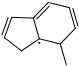

Molecule SMILES: CC1C=CC=C2C=CC[C]21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([183.845, 238.237, 282.253, 314.344, 362.878, 395.681, 447.06], 'J/(mol*K)'),
    H298 = (250.107, 'kJ/mol'),
    S298 = (131.532, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(pdt21) + radical(Allyl_T)',
)
H298 = 59.777 kcal/mol
S298 = 31.4368305179 cal/mol*K
Matched polycyclic group "pdt21"
Molecule CC1C=C[CH]C2C=CCC=21 has a single polycyclic group match in thermo estimate.


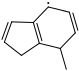

Molecule SMILES: CC1C=C[CH]C2C=CCC=21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.849, 237.986, 280.705, 313.549, 361.79, 395.765, 447.437], 'J/(mol*K)'),
    H298 = (233.413, 'kJ/mol'),
    S298 = (144.502, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 55.787 kcal/mol
S298 = 34.5368305179 cal/mol*K
1 * Cd u0 {4,S} {6,D}
2   Cs u0 {5,S} {9,S}
3   Cs u0 {4,S} {7,S}
4   Cd u0 {1,S} {3,S} {9,D}
5   Cd u0 {2,S} {7,D}
6   Cd u0 {1,D} {8,S}
7   Cd u0 {3,S} {5,D}
8   Cs u0 {6,S} {9,S}
9   Cd u

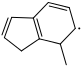

Molecule SMILES: CC1[CH]C=CC2C=CCC=21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([175.184, 228.154, 271.918, 305.976, 358.234, 393.589, 446.433], 'J/(mol*K)'),
    H298 = (273.83, 'kJ/mol'),
    S298 = (138.31, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 65.447 kcal/mol
S298 = 33.0568305179 cal/mol*K
1 * Cd u0 {4,S} {7,D}
2   Cd u0 {5,S} {8,D}
3   Cs u0 {6,S} {9,S}
4   Cs u0 {1,S} {9,S}
5   Cd u0 {2,S} {7,S} {9,D}
6   Cs u0 {3,S} {8,S}
7   Cd u0 {1,D} {5,S}
8   Cd u0 {2,D} {6,S}
9   Cd u0 

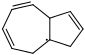

Molecule SMILES: C1C=CC2C=CC[C]2CC=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([187.611, 232.128, 270.579, 302.085, 350.41, 384.719, 435.889], 'J/(mol*K)'),
    H298 = (333.871, 'kJ/mol'),
    S298 = (185.686, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(pdt8-2) + radical(Tertalkyl)',
)
H298 = 79.797 kcal/mol
S298 = 44.38 cal/mol*K
Matched polycyclic group "pdt8-2"
pdt29
Species has 4 resonance isomers
Molecule [CH]1C=CC=C2C=CCC2C1 has a single polycyclic group match in thermo estimate.


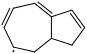

Molecule SMILES: [CH]1C=CC=C2C=CCC2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([186.021, 240.831, 284.303, 316.478, 364.301, 396.811, 444.759], 'J/(mol*K)'),
    H298 = (267.638, 'kJ/mol'),
    S298 = (142.256, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 63.967 kcal/mol
S298 = 34.0 cal/mol*K
1  * Cd u0 {4,D} {9,S} {10,S}
2    Cd u0 {4,S} {7,D}
3    Cs u0 {6,S} {9,S}
4    Cd u0 {1,D} {2,S}
5    Cs u0 {7,S} {8,S}
6    Cd u0 {3,S} {10,D}
7    Cd u0 {2,D} {5,S}
8    Cs u0 {5,S} {9,S}
9    Cs u0 {1,

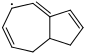

Molecule SMILES: [CH]1C=CCC2CC=CC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([177.694, 233.258, 277.901, 311.624, 361.707, 395.639, 447.604], 'J/(mol*K)'),
    H298 = (245.295, 'kJ/mol'),
    S298 = (157.82, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 58.627 kcal/mol
S298 = 37.72 cal/mol*K
1  * Cs u0 {2,S} {3,S}
2    Cd u0 {1,S} {9,D}
3    Cd u0 {1,S} {6,D}
4    Cs u0 {6,S} {8,S} {10,S}
5    Cd u0 {7,D} {10,S}
6    Cd u0 {3,D} {4,S} {7,S}
7    Cd u0 {5,D} {6,S}
8    Cs u0 {4,S} {9,S}
9    Cd

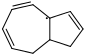

Molecule SMILES: C1C=C[C]2C=CCC2CC=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([187.611, 232.128, 270.579, 302.085, 350.41, 384.719, 435.889], 'J/(mol*K)'),
    H298 = (333.871, 'kJ/mol'),
    S298 = (185.686, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(pdt8-2) + radical(Tertalkyl)',
)
H298 = 79.797 kcal/mol
S298 = 44.38 cal/mol*K
Matched polycyclic group "pdt8-2"
Molecule [CH]1C=C2C=CC=CCC2C1 has a single polycyclic group match in thermo estimate.


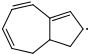

Molecule SMILES: [CH]1C=C2C=CC=CCC2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([186.021, 240.831, 284.303, 316.478, 364.301, 396.811, 444.759], 'J/(mol*K)'),
    H298 = (253.831, 'kJ/mol'),
    S298 = (142.256, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 60.667 kcal/mol
S298 = 34.0 cal/mol*K
1  * Cs u0 {4,S} {8,S} {10,S}
2    Cd u0 {5,D} {7,S}
3    Cs u0 {9,S} {10,S}
4    Cs u0 {1,S} {5,S}
5    Cd u0 {2,D} {4,S}
6    Cd u0 {7,D} {8,S}
7    Cd u0 {2,S} {6,D}
8    Cd u0 {1,S} {6,S} {9,

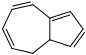

Molecule SMILES: C1C=CC2=CC=CC2CC=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([190.037, 241.752, 281.541, 310.662, 352.376, 381.288, 424.509], 'J/(mol*K)'),
    H298 = (226.354, 'kJ/mol'),
    S298 = (125.562, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 54.1 kcal/mol
S298 = 30.01 cal/mol*K
1  * Cd u0 {3,S} {8,D}
2    Cd u0 {7,D} {10,S}
3    Cs u0 {1,S} {4,S}
4    Cs u0 {3,S} {6,S} {7,S}
5    Cd u0 {6,S} {9,D}
6    Cd u0 {4,S} {5,S} {10,D}
7    Cd u0 {2,D} {4,S}
8    Cd u0 {1,D} {9,S}
9    Cd u0 {5,

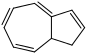

Molecule SMILES: C1=CC=C2C=CCC2C=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([190.037, 241.752, 281.541, 310.662, 352.376, 381.288, 424.509], 'J/(mol*K)'),
    H298 = (226.354, 'kJ/mol'),
    S298 = (125.562, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 54.1 kcal/mol
S298 = 30.01 cal/mol*K
1    Cs u0 {4,S} {9,S} {10,S}
2    Cd u0 {6,S} {8,D}
3  * Cd u0 {8,S} {9,D}
4    Cd u0 {1,S} {6,D}
5    Cd u0 {7,D} {9,S}
6    Cd u0 {2,S} {4,D}
7    Cd u0 {5,D} {10,S}
8    Cd u0 {2,D} {3,S}
9    Cd u0 {1,S} {3,

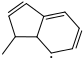

Molecule SMILES: CC1C=CC2=CC=C[CH]C21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([184.891, 240.58, 285.014, 317.064, 365.096, 397.396, 445.805], 'J/(mol*K)'),
    H298 = (259.312, 'kJ/mol'),
    S298 = (131.03, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(pdt21) + radical(Allyl_S)',
)
H298 = 61.977 kcal/mol
S298 = 31.3168305179 cal/mol*K
Matched polycyclic group "pdt21"
Molecule CC1C=CC2=C[CH]C=CC21 has a single polycyclic group match in thermo estimate.


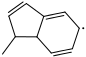

Molecule SMILES: CC1C=CC2=C[CH]C=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([182.841, 236.019, 279.7, 312.838, 361.832, 395.597, 448.023], 'J/(mol*K)'),
    H298 = (237.848, 'kJ/mol'),
    S298 = (139.398, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 56.847 kcal/mol
S298 = 33.3168305179 cal/mol*K
1 * Cd u0 {2,S} {5,D}
2   Cs u0 {1,S} {6,S}
3   Cd u0 {4,D} {5,S} {6,S}
4   Cd u0 {3,D} {7,S}
5   Cd u0 {1,D} {3,S}
6   Cs u0 {2,S} {3,S} {9,S}
7   Cs u0 {4,S} {8,S}
8   Cd u0 {7,S} {9,D}
9   Cd u0 

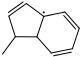

Molecule SMILES: CC1C=C[C]2C=CC=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([186.481, 231.877, 271.709, 302.671, 351.205, 385.305, 436.935], 'J/(mol*K)'),
    H298 = (326.59, 'kJ/mol'),
    S298 = (174.46, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Tertalkyl)',
)
H298 = 78.057 kcal/mol
S298 = 41.6968305179 cal/mol*K
1 * Cd u0 {2,S} {7,D}
2   Cs u0 {1,S} {3,S}
3   Cs u0 {2,S} {8,S} {9,S}
4   Cd u0 {5,D} {6,S}
5   Cd u0 {4,D} {9,S}
6   Cd u0 {4,S} {8,D}
7   Cd u0 {1,D} {9,S}
8   Cd u0 {3,S} {6,D}
9   Cs u0 {3,S} {5,S} {

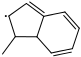

Molecule SMILES: CC1[CH]C=C2C=CC=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([191.167, 243.592, 285.684, 317.691, 364.426, 396.769, 445.178], 'J/(mol*K)'),
    H298 = (245.337, 'kJ/mol'),
    S298 = (123.833, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-CsHHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(cyclopentene-allyl)',
)
H298 = 58.637 kcal/mol
S298 = 29.5968305179 cal/mol*K
1 * Cd u0 {5,S} {9,D}
2   Cd u0 {3,S} {8,D}
3   Cs u0 {2,S} {6,S}
4   Cs u0 {6,S} {8,S} {9,S}
5   Cd u0 {1,S} {7,D}
6   Cs u0 {3,S} {4,S}
7   Cd u0 {5,D} {8,S}
8   Cd u0 {2,D} {4,S} {7,S

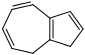

Molecule SMILES: C1C=CC2C=CCC=2CC=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([173.887, 226.438, 267.399, 298.821, 345.891, 378.024, 425.471], 'J/(mol*K)'),
    H298 = (241.249, 'kJ/mol'),
    S298 = (140.122, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 57.66 kcal/mol
S298 = 33.49 cal/mol*K
1  * Cs u0 {4,S} {5,S}
2    Cd u0 {7,D} {9,S}
3    Cd u0 {9,S} {10,D}
4    Cd u0 {1,S} {8,D}
5    Cd u0 {1,S} {6,S} {9,D}
6    Cs u0 {5,S} {10,S}
7    Cd u0 {2,D} {8,S}
8    Cd u0 {4,D} {7,S}
9    Cd u0 {

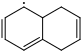

Molecule SMILES: [CH]1C=CC=C2CC=CCC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([180.163, 233.844, 277.064, 309.825, 359.406, 393.38, 442.374], 'J/(mol*K)'),
    H298 = (283.997, 'kJ/mol'),
    S298 = (160.122, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(pdt19) + radical(Allyl_S)',
)
H298 = 67.877 kcal/mol
S298 = 38.27 cal/mol*K
Matched polycyclic group "pdt19"
Molecule [CH]1C=CC2CC=CCC2=C1 has a single polycyclic group match in thermo estimate.


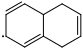

Molecule SMILES: [CH]1C=CC2CC=CCC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([178.113, 229.283, 271.751, 305.599, 356.142, 391.581, 444.592], 'J/(mol*K)'),
    H298 = (262.533, 'kJ/mol'),
    S298 = (168.49, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsCs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 62.747 kcal/mol
S298 = 40.27 cal/mol*K
1  * Cd u0 {8,D} {10,S}
2    Cs u0 {4,S} {8,S}
3    Cd u0 {5,S} {7,D}
4    Cd u0 {2,S} {9,D}
5    Cs u0 {3,S} {10,S}
6    Cs u0 {7,S} {9,S}
7    Cd u0 {3,D} {6,S}
8    Cd u0 {1,D} {2,S}
9    Cd u0 {4,D} {6

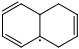

Molecule SMILES: C1C=CC2CC=CC[C]2C=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([177.109, 229.534, 273.299, 306.394, 357.23, 391.497, 444.215], 'J/(mol*K)'),
    H298 = (279.228, 'kJ/mol'),
    S298 = (155.519, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(pdt10bis) + radical(Allyl_T)',
)
H298 = 66.737 kcal/mol
S298 = 37.17 cal/mol*K
Matched polycyclic group "pdt10bis"
pdt38
Species has 2 resonance isomers
Molecule C1=CC=C2CC=CCC2=C1 has a single polycyclic group match in thermo estimate.


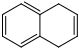

Molecule SMILES: C1=CC=C2CC=CCC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([185.602, 240.831, 281.5, 310.62, 352.711, 381.999, 424.258], 'J/(mol*K)'),
    H298 = (223.76, 'kJ/mol'),
    S298 = (136.649, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 53.48 kcal/mol
S298 = 32.66 cal/mol*K
1  * Cd u0 {2,S} {5,S} {7,D}
2    Cs u0 {1,S} {4,S}
3    Cd u0 {7,S} {8,D}
4    Cd u0 {2,S} {6,D}
5    Cd u0 {1,S} {9,D} {10,S}
6    Cd u0 {4,D} {10,S}
7    Cd u0 {1,D} {3,S}
8    Cd u0 {3,D} {9,S}
9    Cd u0

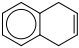

Molecule SMILES: C1=CCc2ccccc2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([149.118, 199.242, 242.839, 278.32, 331.875, 369.112, 422.835], 'J/(mol*K)'),
    H298 = (137.319, 'kJ/mol'),
    S298 = (212.045, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CbHH) + other(R) + group(Cs-(Cds-Cds)CbHH) + other(R) + group(Cb-Cs) + other(R) + group(Cb-Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 32.82 kcal/mol
S298 = 50.68 cal/mol*K
1  * Cs u0 {4,S} {6,S}
2    Cb u0 {3,B} {4,B} {7,S}
3    Cb u0 {2,B} {10,B}
4    Cb u0 {1,S} {2,B} {9,B}
5    Cd u0 {6,D} {7,S}
6    Cd u0 {1,S} {5,D}
7    Cs u0 {2,S} {5,S}
8    Cb u0 {9,B} {10,B}
9    Cb u0 {4,B} {8,B}
10   Cb u0 {3,B} {8,B}

Polycyclic group was found to be generic "PolycyclicRin

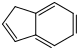

Molecule SMILES: C1=CC=C2CC=CC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([156.733, 204.347, 240.12, 266.353, 304.47, 329.825, 368.234], 'J/(mol*K)'),
    H298 = (245.517, 'kJ/mol'),
    S298 = (82.8432, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 58.68 kcal/mol
S298 = 19.8 cal/mol*K
1 * Cd u0 {6,D} {7,S}
2   Cd u0 {5,D} {9,S}
3   Cd u0 {7,D} {8,S}
4   Cd u0 {5,S} {6,S} {8,D}
5   Cd u0 {2,D} {4,S}
6   Cd u0 {1,D} {4,S} {9,S}
7   Cd u0 {1,S} {3,D}
8   Cd u0 {3,S} {4,D}
9   Cs u0 {2,S} {6,S}

Polycyclic group was found 

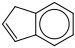

Molecule SMILES: C1=Cc2ccccc2C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([119.118, 159.661, 197.401, 230.287, 278.403, 306.813, 353.171], 'J/(mol*K)'),
    H298 = (157.235, 'kJ/mol'),
    S298 = (334.971, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CbHH) + other(R) + group(Cb-Cs) + other(R) + group(Cb-(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cb-H) + other(R) + group(Cds-CdsCbH) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + polycyclic(indene)',
)
H298 = 37.58 kcal/mol
S298 = 80.06 cal/mol*K
Matched polycyclic group "indene"
Molecule C1C=CC2CC=CC=2C=1 has a single polycyclic group match in thermo estimate.


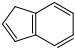

Molecule SMILES: C1C=CC2CC=CC=2C=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([156.733, 204.347, 240.12, 266.353, 304.47, 329.825, 368.234], 'J/(mol*K)'),
    H298 = (245.517, 'kJ/mol'),
    S298 = (82.8432, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 58.68 kcal/mol
S298 = 19.8 cal/mol*K
1 * Cd u0 {4,D} {5,S}
2   Cd u0 {8,D} {9,S}
3   Cd u0 {6,S} {7,D}
4   Cd u0 {1,D} {8,S}
5   Cd u0 {1,S} {6,S} {9,D}
6   Cs u0 {3,S} {5,S}
7   Cd u0 {3,D} {9,S}
8   Cd u0 {2,D} {4,S}
9   Cd u0 {2,S} {5,D} {7,S}

Polycyclic group was found 

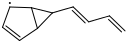

Molecule SMILES: C=CC=CC1C2[CH]C=CC21
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([179.661, 233.844, 278.362, 311.457, 361.581, 394.844, 444.55], 'J/(mol*K)'),
    H298 = (276.843, 'kJ/mol'),
    S298 = (145.687, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-CdsHH) + other(R) + polycyclic(product1) + radical(cyclopentene-allyl)',
)
H298 = 66.167 kcal/mol
S298 = 34.82 cal/mol*K
Matched polycyclic group "product1"
2HINDENE
Species has 1 resonance isomers
Molecule C1C=CC2=CCC=C2C=1 has a single polycyclic group match in thermo estimate.


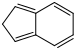

Molecule SMILES: C1C=CC2=CCC=C2C=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([145.017, 189.954, 226.02, 254.555, 297.65, 325.85, 369.447], 'J/(mol*K)'),
    H298 = (264.471, 'kJ/mol'),
    S298 = (85.0189, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 63.21 kcal/mol
S298 = 20.32 cal/mol*K
1 * Cd u0 {4,S} {7,D}
2   Cd u0 {4,D} {6,S}
3   Cd u0 {4,S} {5,S} {9,D}
4   Cd u0 {1,S} {2,D} {3,S}
5   Cd u0 {3,S} {8,D}
6   Cs u0 {2,S} {9,S}
7   Cd u0 {1,D} {8,S}
8   Cd u0 {5,D} {7,S}
9   Cd u0 {3,D} {6,S}

Polycyclic group was found 

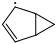

Molecule SMILES: [CH]1C=CC2CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([109.202, 142.089, 169.954, 191.46, 224.304, 246.103, 278.027], 'J/(mol*K)'),
    H298 = (143.54, 'kJ/mol'),
    S298 = (31.7566, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-CsCsHH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + polycyclic(product1) + radical(cyclopentene-allyl)',
)
H298 = 34.307 kcal/mol
S298 = 7.59 cal/mol*K
Matched polycyclic group "product1"
prod1
Species has 1 resonance isomers
Molecule [CH]1C=CC2C1C21C=CC=C1 has a single polycyclic group match in thermo estimate.


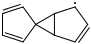

Molecule SMILES: [CH]1C=CC2C1C21C=CC=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([175.017, 228.823, 271.625, 303.382, 349.197, 377.899, 416.852], 'J/(mol*K)'),
    H298 = (299.813, 'kJ/mol'),
    S298 = (-32.8444, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsCs) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(product1) + radical(cyclopentene-allyl)',
)
H298 = 71.657 kcal/mol
S298 = -7.85 cal/mol*K
Matched polycyclic group "product1"
prod2
Species has 2 resonance isomers
Molecule [CH]1C=CC=CC12C=CC=C2 has a single polycyclic group match in thermo estimate.


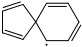

Molecule SMILES: [CH]1C=CC=CC12C=CC=C2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([173.134, 226.689, 267.985, 298.696, 341.791, 370.117, 407.354], 'J/(mol*K)'),
    H298 = (388.095, 'kJ/mol'),
    S298 = (123.135, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)(Cds-Cds)Cs) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Allyl_S)',
)
H298 = 92.757 kcal/mol
S298 = 29.43 cal/mol*K
1  * Cs u0 {5,S} {9,S}
2    Cd u0 {4,D} {7,S}
3    Cd u0 {8,D} {10,S}
4    Cd u0 {2,D} {5,S}
5    Cs u0 {1,S} {4,S} {6,S} {8,S}
6    Cd u0 {5,S} {10,D}
7    Cd u0 {2,S} {9,D}
8    Cd u0 {3,D} {5,

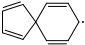

Molecule SMILES: [CH]1C=CC2(C=C1)C=CC=C2
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([170.791, 220.622, 260.412, 291.499, 336.686, 365.849, 408.358], 'J/(mol*K)'),
    H298 = (356.506, 'kJ/mol'),
    S298 = (132.34, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-CsCsCsCs) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 85.207 kcal/mol
S298 = 31.63 cal/mol*K
1  * Cd u0 {5,S} {10,D}
2    Cd u0 {4,D} {9,S}
3    Cs u0 {4,S} {6,S}
4    Cd u0 {2,D} {3,S}
5    Cd u0 {1,S} {8,D}
6    Cd u0 {3,S} {7,D}
7    Cd u0 {6,D} {9,S}
8    Cd u0 {5,D} {9,S}
9    Cs u0 {2,S} {7,S} {8,S} {10,S}


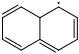

Molecule SMILES: [CH]1C=CC=C2C=CC=CC12
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([183.594, 234.137, 272.839, 300.955, 340.87, 368.15, 408.4], 'J/(mol*K)'),
    H298 = (366.506, 'kJ/mol'),
    S298 = (109.621, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(pdt11) + radical(Allyl_S)',
)
H298 = 87.597 kcal/mol
S298 = 26.2 cal/mol*K
Matched polycyclic group "pdt11"
Molecule [CH]1C=CC2C=CC=CC2=C1 has a single polycyclic group match in thermo estimate.


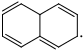

Molecule SMILES: [CH]1C=CC2C=CC=CC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([173.636, 224.513, 263.885, 293.424, 336.017, 365.221, 410.743], 'J/(mol*K)'),
    H298 = (349.77, 'kJ/mol'),
    S298 = (128.658, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)(Cds-Cds)H) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)HH) + other(R) + group(Cds-Cds(Cds-Cds)Cs) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(C=CCJC=C)',
)
H298 = 83.597 kcal/mol
S298 = 30.75 cal/mol*K
1  * Cd u0 {6,D} {8,S}
2    Cd u0 {8,S} {10,D}
3    Cs u0 {4,S} {6,S}
4    Cd u0 {3,S} {5,D}
5    Cd u0 {4,D} {8,S} {9,S}
6    Cd u0 {1,D} {3,S}
7    Cd u0 {9,D} {10,S}
8    Cs u0 {1,S} {2

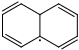

Molecule SMILES: C1C=CC2C=CC=C[C]2C=1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([185.184, 225.434, 259.534, 286.562, 326.98, 356.058, 399.53], 'J/(mol*K)'),
    H298 = (433.785, 'kJ/mol'),
    S298 = (153.051, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cs-(Cds-Cds)(Cds-Cds)CsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing) + radical(Tertalkyl)',
)
H298 = 103.677 kcal/mol
S298 = 36.58 cal/mol*K
1  * Cs u0 {3,S} {4,S} {8,S}
2    Cd u0 {5,S} {7,D}
3    Cd u0 {1,S} {5,D}
4    Cd u0 {1,S} {9,D}
5    Cd u0 {2,S} {3,D}
6    Cd u0 {8,S} {10,D}
7    Cd u0 {2,D} {8,S}
8    Cs u0 {1,S} {6,S} {7,S

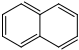

Molecule SMILES: C1=CC=C2C=CC=CC2=C1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([165.184, 216.313, 255.224, 284.177, 326.101, 352.879, 395.723], 'J/(mol*K)'),
    H298 = (324.009, 'kJ/mol'),
    S298 = (82.4248, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-Cds(Cds-Cds)(Cds-Cds)) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 77.44 kcal/mol
S298 = 19.7 cal/mol*K
1  * Cd u0 {2,D} {9,S}
2    Cd u0 {1,D} {10,S}
3    Cd u0 {4,D} {6,S}
4    Cd u0 {3,D} {5,S}
5    Cd u0 {4,S} {7,D}
6    Cd u0 {3,S} {10,D}
7    Cd u0 {5,D} {8,S} {10,S}
8    Cd u0 {7,S} {

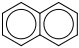

Molecule SMILES: c1ccc2ccccc2c1
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([133.637, 179.41, 217.903, 249.45, 295.892, 329.197, 377.564], 'J/(mol*K)'),
    H298 = (150.624, 'kJ/mol'),
    S298 = (344.092, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cbf-CbCbCbf) + other(R) + group(Cbf-CbCbCbf) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + group(Cb-H) + other(R) + polycyclic(PolycyclicRing)',
)
H298 = 36.0 kcal/mol
S298 = 82.24 cal/mol*K
1    Cb  u0 {5,B} {8,B}
2    Cbf u0 {3,B} {4,B} {6,B}
3    Cbf u0 {2,B} {7,B} {8,B}
4    Cb  u0 {2,B} {9,B}
5    Cb  u0 {1,B} {6,B}
6    Cb  u0 {2,B} {5,B}
7    Cb  u0 {3,B} {10,B}
8  * Cb  u0 {1,B} {3,B}
9    Cb  u0 {4,B} {10,B}
10   Cb  u0 {7,B} {9,B}

Polycyclic group was found to be generic "PolycyclicRing". Creating new 

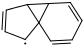

Molecule SMILES: [CH]1C=CC2C3C=CC=CC123
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([173.427, 228.446, 272.337, 303.968, 349.824, 378.485, 417.312], 'J/(mol*K)'),
    H298 = (301.57, 'kJ/mol'),
    S298 = (-31.2545, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)CsCsCs) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(product1) + radical(cyclopentene-allyl)',
)
H298 = 72.077 kcal/mol
S298 = -7.47 cal/mol*K
Matched polycyclic group "product1"
Molecule [CH]1C=CC23C=CC=CC2C13 has a single polycyclic group match in thermo estimate.


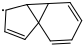

Molecule SMILES: [CH]1C=CC23C=CC=CC2C13
Estimated thermo data:
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([175.017, 228.823, 271.625, 303.382, 349.197, 377.899, 416.852], 'J/(mol*K)'),
    H298 = (299.813, 'kJ/mol'),
    S298 = (-32.8444, 'J/(mol*K)'),
    comment = 'Thermo group additivity estimation: group(Cs-(Cds-Cds)(Cds-Cds)CsCs) + other(R) + group(Cs-CsCsCsH) + other(R) + group(Cs-(Cds-Cds)CsCsH) + other(R) + group(Cs-(Cds-Cds)CsHH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-CdsCsH) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + group(Cds-Cds(Cds-Cds)H) + other(R) + polycyclic(product1) + radical(cyclopentene-allyl)',
)
H298 = 71.657 kcal/mol
S298 = -7.85 cal/mol*K
Matched polycyclic group "product1"


In [5]:
fittingDictionary={}
for libraryName in thermoLibraries:
    thermoLibrary = database.thermo.libraries[libraryName]
    for label, entry in thermoLibrary.entries.iteritems():
        molecule = entry.item
        libraryThermoData = entry.data
        if molecule.getAllPolycyclicVertices():
            print label
            species = Species(molecule=[molecule])
            species.generateResonanceIsomers() 
            print 'Species has {0} resonance isomers'.format(len(species.molecule))

            estimatedThermos = [thermoDatabase.estimateThermoViaGroupAdditivity(molecule) for molecule in species.molecule]
            for estimatedThermo in estimatedThermos:
                index = estimatedThermos.index(estimatedThermo)
                polycyclicGroupTokens = returnPolycyclicGroupStrings(estimatedThermo.comment)
                polycyclicGroups = [thermoDatabase.groups['polycyclic'].entries[token] for token in polycyclicGroupTokens]

                if len(polycyclicGroups) == 0:
                    raise Exception('Species {0} detected as polycyclic but estimated thermo contained no polycyclic groups: \
                            you need to create a new polycyclic group'.format(label))

                elif len(polycyclicGroups) == 1:
                    polycyclicGroup = polycyclicGroups[0]
                    print 'Molecule {0} has a single polycyclic group match in thermo estimate.'.format(species.molecule[index].toSMILES())
                    # Draw the molecule in ipython notebook
                    display(species.molecule[index])
                    print 'Molecule SMILES: {0}'.format(species.molecule[index].toSMILES())
                    print 'Estimated thermo data:'
                    print prettify(repr(estimatedThermo))
                    displayThermo(estimatedThermo)

                    withoutPolycyclicGroupThermo = removeThermoData(copy.deepcopy(estimatedThermo), polycyclicGroup.data)
                    newPolycyclicGroupThermo = removeThermoData(copy.deepcopy(libraryThermoData), withoutPolycyclicGroupThermo)


                    # Check to make sure that the polycyclic group is not generic
                    # If it is, create a new polycyclicGroup as the child
                    if polycyclicGroup.label == 'PolycyclicRing':
                        groups = extractPolycyclicGroups(species.molecule[index])
                        print groups[0].toAdjacencyList()
                        assert len(groups) == 1
                        # Create a new entry in the polycyclic groups with the same name as the thermo library entry
                        # Make sure it does not already exist
                        entryLabel = label
                        counter = 0
                        while entryLabel in thermoDatabase.groups['polycyclic'].entries:
                            counter += 1
                            entryLabel = entryLabel.split('-')[0]
                            entryLabel += '-{0}'.format(counter)


                        print 'Polycyclic group was found to be generic "PolycyclicRing". Creating new entry: {0}.'.format(entryLabel)
                        thermoDatabase.groups['polycyclic'].entries[entryLabel] = Entry(index = len(thermoDatabase.groups['polycyclic'].entries)+1,
                                                                                  label = entryLabel,
                                                                                   item = groups[0],
                                                                                   data = polycyclicGroup.data, # Use dummy thermo here so other estimates can find this group
                                                                                   parent = polycyclicGroup,
                                                                                  )

                        # Set the new entry as the polycyclicGroup and make it a child of the generic group
                        polycyclicGroup = thermoDatabase.groups['polycyclic'].entries[entryLabel] 
                        thermoDatabase.groups['polycyclic'].entries['PolycyclicRing'].children.append(polycyclicGroup)


                    else:
                        print 'Matched polycyclic group "{0}"'.format(polycyclicGroup.label)





                    # Add the new group value to the fitting dictionary
                    if polycyclicGroup not in fittingDictionary:
                        # Add a tuple containing fitted group data, the original library entry, and thermo library
                        fittingDictionary[polycyclicGroup]=[(newPolycyclicGroupThermo, entry, thermoLibrary)]
                    else:
                        fittingDictionary[polycyclicGroup].append((newPolycyclicGroupThermo, entry, thermoLibrary))

                elif len(polycyclicGroups) > 1:
                    print 'Species {0} has matched multiple polycyclic groups. \
                            This cannot be fitted with a single molecule\'s thermo data.'.format(label)
                    raise Exception
            print '====================='

## Fit the polycyclic groups and write to file

In [6]:
for polycyclicGroup, fittingGroups in fittingDictionary.iteritems():
    print 'Original thermo data for polycyclic group: {0}'.format(polycyclicGroup.label)
    if polycyclicGroup.data:
        print prettify(repr(polycyclicGroup.data))
    else:
        print 'No data found. Was created as a new group.'
    
    thermoDataset = [fitTuple[0] for fitTuple in fittingGroups]
    labels = [fitTuple[1].label for fitTuple in fittingGroups]
    libraryLabels = [fitTuple[2].name for fitTuple in fittingGroups]
    # Average the new group values to fit the original polycyclic group
    fittedGroupData = averageThermoData([fitTuple[0] for fitTuple in fittingGroups])
    #print fittedGroupData
    #print fittingGroups
    polycyclicGroup.data = fittedGroupData
    polycyclicGroup.shortDesc = "Fitted from thermo library values"
    
    comment = ''
    for i in range(len(labels)):
        comment += "Fitted from species {0} from {1} library.\n".format(labels[i],libraryLabels[i])
    polycyclicGroup.longDesc = comment.strip()
    
    print 'Fitted thermo data for polycyclic group: {0}'.format(polycyclicGroup.label)
    print prettify(repr(polycyclicGroup.data))
    print polycyclicGroup.longDesc
    print '===================================================================='
    # At this point, save and overwrite the entire polycyclic thermo library

thermoDatabase.groups['polycyclic'].save('new_polycyclic.py')

Original thermo data for polycyclic group: pdt8-1
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([0, 0, 0, 0, 0, 0, 0], 'cal/(mol*K)'),
    H298 = (0, 'kcal/mol'),
    S298 = (0, 'cal/(mol*K)'),
    comment = 'polycyclic(product1)',
)
Averaging thermo data over 1 value(s).
Fitted thermo data for polycyclic group: pdt8-1
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([-6.31, -5.81, -5.33, -4.69, -3.97, -3.35, -2.88], 'cal/(mol*K)'),
    H298 = (14.973, 'kcal/mol'),
    S298 = (52.13, 'cal/(mol*K)'),
)
Fitted from species pdt8 from C10H11 library.
Original thermo data for polycyclic group: product46-1
ThermoData(
    Tdata = ([300, 400, 500, 600, 800, 1000, 1500], 'K'),
    Cpdata = ([0, 0, 0, 0, 0, 0, 0], 'cal/(mol*K)'),
    H298 = (0, 'kcal/mol'),
    S298 = (0, 'cal/(mol*K)'),
    comment = 'polycyclic(product1)',
)
Averaging thermo data over 1 value(s).
Fitted thermo data for polycyclic group: product46-1
Therm

## Benchmark the new groups by checking the estimates against library values

product1


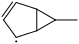

Species has 1 resonance isomer(s)
Library thermo data for species product1 does not match the estimate from group additivity

Library thermo data:
H298 = 62.21 kcal/mol
S298 = 79.16 cal/mol*K

Estimated thermo data:
Polycyclic groups: product1
H298 = 60.9141666667 kcal/mol
S298 = 90.2471939857 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 1.29583333333 kcal/mol
Difference S298 = -11.0871939857 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 27.137 kcal/mol
S298 = 14.3268305179 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 35.073 kcal/mol
Difference S298 = 64.8331694821 cal/mol*K

product3


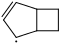

Species has 1 resonance isomer(s)
Library thermo data for species product3 does not match the estimate from group additivity

Library thermo data:
H298 = 63.77 kcal/mol
S298 = 78.59 cal/mol*K

Estimated thermo data:
Polycyclic groups: product3
H298 = 67.008 kcal/mol
S298 = 88.27 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = -3.238 kcal/mol
Difference S298 = -9.68 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 29.377 kcal/mol
S298 = 17.01 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 34.393 kcal/mol
Difference S298 = 61.58 cal/mol*K

product6


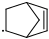

Species has 1 resonance isomer(s)
Library thermo data for species product6 does not match the estimate from group additivity

Library thermo data:
H298 = 68.14 kcal/mol
S298 = 76.39 cal/mol*K

Estimated thermo data:
Polycyclic groups: norbornene
H298 = 78.8866666667 kcal/mol
S298 = 78.4766666667 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = -10.7466666667 kcal/mol
Difference S298 = -2.08666666667 cal/mol*K

Original estimated thermo data:
Polycyclic groups: norbornene
H298 = 63.577 kcal/mol
S298 = 79.01 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 4.563 kcal/mol
Difference S298 = -2.62 cal/mol*K

product8


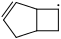

Species has 1 resonance isomer(s)
Library thermo data for species product8 does not match the estimate from group additivity

Library thermo data:
H298 = 79.77 kcal/mol
S298 = 80.18 cal/mol*K

Estimated thermo data:
Polycyclic groups: product3
H298 = 81.608 kcal/mol
S298 = 96.59 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = -1.838 kcal/mol
Difference S298 = -16.41 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 43.977 kcal/mol
S298 = 25.33 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 35.793 kcal/mol
Difference S298 = 54.85 cal/mol*K

product17


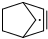

Species has 1 resonance isomer(s)
Library thermo data for species product17 matches the estimate from group additivity.

Library thermo data:
H298 = 74.29 kcal/mol
S298 = 75.05 cal/mol*K

Original estimated thermo data:
Polycyclic groups: norbornene
H298 = 61.827 kcal/mol
S298 = 79.08 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 12.463 kcal/mol
Difference S298 = -4.03 cal/mol*K

product19


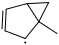

Species has 2 resonance isomer(s)
Library thermo data for species product19 does not match the estimate from group additivity

Library thermo data:
H298 = 61.77 kcal/mol
S298 = 80.32 cal/mol*K

Estimated thermo data:
Polycyclic groups: product1
H298 = 60.2841666667 kcal/mol
S298 = 88.7071939857 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 1.48583333333 kcal/mol
Difference S298 = -8.38719398567 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 26.507 kcal/mol
S298 = 12.7868305179 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 35.263 kcal/mol
Difference S298 = 67.5331694821 cal/mol*K

product23


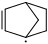

Species has 2 resonance isomer(s)
Library thermo data for species product23 does not match the estimate from group additivity

Library thermo data:
H298 = 77.43 kcal/mol
S298 = 75.93 cal/mol*K

Estimated thermo data:
Polycyclic groups: norbornene
H298 = 63.8366666667 kcal/mol
S298 = 70.3466666667 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 13.5933333333 kcal/mol
Difference S298 = 5.58333333333 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 28.017 kcal/mol
S298 = 18.21 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 49.413 kcal/mol
Difference S298 = 57.72 cal/mol*K

product25


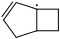

Species has 2 resonance isomer(s)
Library thermo data for species product25 does not match the estimate from group additivity

Library thermo data:
H298 = 73.44 kcal/mol
S298 = 79.16 cal/mol*K

Estimated thermo data:
Polycyclic groups: product3
H298 = 68.108 kcal/mol
S298 = 88.39 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 5.332 kcal/mol
Difference S298 = -9.23 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 28.267 kcal/mol
S298 = 18.21 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 45.173 kcal/mol
Difference S298 = 60.95 cal/mol*K

product29


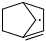

Species has 2 resonance isomer(s)
Library thermo data for species product29 does not match the estimate from group additivity

Library thermo data:
H298 = 122.34 kcal/mol
S298 = 77.13 cal/mol*K

Estimated thermo data:
Polycyclic groups: product23
H298 = 99.885 kcal/mol
S298 = 76.53 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 22.455 kcal/mol
Difference S298 = 0.6 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 28.017 kcal/mol
S298 = 18.21 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 94.323 kcal/mol
Difference S298 = 58.92 cal/mol*K

product34


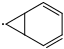

Species has 1 resonance isomer(s)
Library thermo data for species product34 does not match the estimate from group additivity

Library thermo data:
H298 = 111.3 kcal/mol
S298 = 76.88 cal/mol*K

Estimated thermo data:
Polycyclic groups: product34
H298 = 118.66 kcal/mol
S298 = 81.555 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = -7.36 kcal/mol
Difference S298 = -4.675 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 76.747 kcal/mol
S298 = 19.25 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 34.553 kcal/mol
Difference S298 = 57.63 cal/mol*K

product36


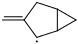

Species has 2 resonance isomer(s)
Library thermo data for species product36 matches the estimate from group additivity.

Library thermo data:
H298 = 64.39 kcal/mol
S298 = 79.77 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 31.757 kcal/mol
S298 = 17.2025734167 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 32.633 kcal/mol
Difference S298 = 62.5674265833 cal/mol*K

product39


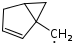

Species has 1 resonance isomer(s)
Library thermo data for species product39 does not match the estimate from group additivity

Library thermo data:
H298 = 76.86 kcal/mol
S298 = 80.94 cal/mol*K

Estimated thermo data:
Polycyclic groups: product1
H298 = 79.8441666667 kcal/mol
S298 = 96.3529368844 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = -2.98416666667 kcal/mol
Difference S298 = -15.4129368844 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 46.067 kcal/mol
S298 = 20.4325734167 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 30.793 kcal/mol
Difference S298 = 60.5074265833 cal/mol*K

product42


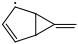

Species has 1 resonance isomer(s)
Library thermo data for species product42 matches the estimate from group additivity.

Library thermo data:
H298 = 103.96 kcal/mol
S298 = 77.63 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 56.637 kcal/mol
S298 = 10.7425734167 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 47.323 kcal/mol
Difference S298 = 66.8874265833 cal/mol*K

product45


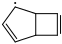

Species has 1 resonance isomer(s)
Library thermo data for species product45 matches the estimate from group additivity.

Library thermo data:
H298 = 96.7 kcal/mol
S298 = 75.31 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 57.217 kcal/mol
S298 = 13.15 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 39.483 kcal/mol
Difference S298 = 62.16 cal/mol*K

product46


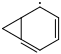

Species has 3 resonance isomer(s)
Library thermo data for species product46 does not match the estimate from group additivity

Library thermo data:
H298 = 103.42 kcal/mol
S298 = 78.03 cal/mol*K

Estimated thermo data:
Polycyclic groups: product34
H298 = 96.06 kcal/mol
S298 = 73.355 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 7.36 kcal/mol
Difference S298 = 4.675 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 49.857 kcal/mol
S298 = 14.13 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 53.563 kcal/mol
Difference S298 = 63.9 cal/mol*K

pdt7


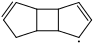

Species has 2 resonance isomer(s)
Library thermo data for species pdt7 does not match the estimate from group additivity

Library thermo data:
H298 = 85.78 kcal/mol
S298 = 89.07 cal/mol*K

Estimated thermo data:
Polycyclic groups: product3
H298 = 85.908 kcal/mol
S298 = 71.41 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = -0.128 kcal/mol
Difference S298 = 17.66 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 48.277 kcal/mol
S298 = 0.15 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 37.503 kcal/mol
Difference S298 = 88.92 cal/mol*K

pdt8


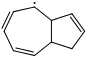

Species has 3 resonance isomer(s)
Library thermo data for species pdt8 matches the estimate from group additivity.

Library thermo data:
H298 = 78.78 kcal/mol
S298 = 91.18 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 63.807 kcal/mol
S298 = 39.05 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 14.973 kcal/mol
Difference S298 = 52.13 cal/mol*K

pdt10bis


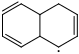

Species has 2 resonance isomer(s)
Library thermo data for species pdt10bis does not match the estimate from group additivity

Library thermo data:
H298 = 76.28 kcal/mol
S298 = 89.92 cal/mol*K

Estimated thermo data:
Polycyclic groups: pdt10bis
H298 = 71.41 kcal/mol
S298 = 89.49 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 4.87 kcal/mol
Difference S298 = 0.43 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 68.337 kcal/mol
S298 = 37.05 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 7.943 kcal/mol
Difference S298 = 52.87 cal/mol*K

pdt11


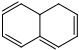

Species has 1 resonance isomer(s)
Library thermo data for species pdt11 does not match the estimate from group additivity

Library thermo data:
H298 = 63.19 kcal/mol
S298 = 87.27 cal/mol*K

Estimated thermo data:
Polycyclic groups: pdt11
H298 = 55.6665 kcal/mol
S298 = 88.75 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 7.5235 kcal/mol
Difference S298 = -1.48 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 54.1 kcal/mol
S298 = 30.01 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 9.09 kcal/mol
Difference S298 = 57.26 cal/mol*K

pdt17


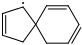

Species has 2 resonance isomer(s)
Library thermo data for species pdt17 matches the estimate from group additivity.

Library thermo data:
H298 = 80.09 kcal/mol
S298 = 92.88 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 65.347 kcal/mol
S298 = 35.13 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 14.743 kcal/mol
Difference S298 = 57.75 cal/mol*K

pdt19


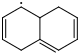

Species has 2 resonance isomer(s)
Library thermo data for species pdt19 does not match the estimate from group additivity

Library thermo data:
H298 = 74.88 kcal/mol
S298 = 91.27 cal/mol*K

Estimated thermo data:
Polycyclic groups: pdt19
H298 = 69.61 kcal/mol
S298 = 90.225 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 5.27 kcal/mol
Difference S298 = 1.045 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 67.187 kcal/mol
S298 = 36.53 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 7.693 kcal/mol
Difference S298 = 54.74 cal/mol*K

pdt21


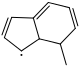

Species has 4 resonance isomer(s)
Library thermo data for species pdt21 does not match the estimate from group additivity

Library thermo data:
H298 = 63.36 kcal/mol
S298 = 91.32 cal/mol*K

Estimated thermo data:
Polycyclic groups: pdt21
H298 = 61.32 kcal/mol
S298 = 91.78 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 2.04 kcal/mol
Difference S298 = -0.46 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 56.497 kcal/mol
S298 = 33.6268305179 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 6.863 kcal/mol
Difference S298 = 57.6931694821 cal/mol*K

pdt22


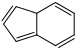

Species has 1 resonance isomer(s)
Library thermo data for species pdt22 matches the estimate from group additivity.

Library thermo data:
H298 = 74.42 kcal/mol
S298 = 81.81 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 60.37 kcal/mol
S298 = 21.42 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 14.05 kcal/mol
Difference S298 = 60.39 cal/mol*K

pdt23


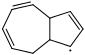

Species has 2 resonance isomer(s)
Library thermo data for species pdt23 does not match the estimate from group additivity

Library thermo data:
H298 = 83.25 kcal/mol
S298 = 91.39 cal/mol*K

Estimated thermo data:
Polycyclic groups: pdt8-2
H298 = 72.355 kcal/mol
S298 = 87.1625 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 10.895 kcal/mol
Difference S298 = 4.2275 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 65.597 kcal/mol
S298 = 35.33 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 17.653 kcal/mol
Difference S298 = 56.06 cal/mol*K

pdt24


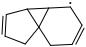

Species has 2 resonance isomer(s)
Library thermo data for species pdt24 does not match the estimate from group additivity

Library thermo data:
H298 = 82.04 kcal/mol
S298 = 88.96 cal/mol*K

Estimated thermo data:
Polycyclic groups: product1
H298 = 83.8741666667 kcal/mol
S298 = 74.5303634677 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = -1.83416666667 kcal/mol
Difference S298 = 14.4296365323 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 50.097 kcal/mol
S298 = -1.39 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 31.943 kcal/mol
Difference S298 = 90.35 cal/mol*K

pdt26


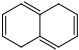

Species has 1 resonance isomer(s)
Library thermo data for species pdt26 matches the estimate from group additivity.

Library thermo data:
H298 = 63.81 kcal/mol
S298 = 86.13 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 53.48 kcal/mol
S298 = 32.66 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 10.33 kcal/mol
Difference S298 = 53.47 cal/mol*K

pdt27


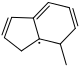

Species has 3 resonance isomer(s)
Library thermo data for species pdt27 does not match the estimate from group additivity

Library thermo data:
H298 = 62.67 kcal/mol
S298 = 92.61 cal/mol*K

Estimated thermo data:
Polycyclic groups: pdt21
H298 = 62.42 kcal/mol
S298 = 91.9 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 0.25 kcal/mol
Difference S298 = 0.71 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 55.787 kcal/mol
S298 = 34.5368305179 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 6.883 kcal/mol
Difference S298 = 58.0731694821 cal/mol*K

pdt28


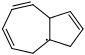

Species has 1 resonance isomer(s)
Library thermo data for species pdt28 does not match the estimate from group additivity

Library thermo data:
H298 = 94.43 kcal/mol
S298 = 93.22 cal/mol*K

Estimated thermo data:
Polycyclic groups: pdt8-2
H298 = 86.555 kcal/mol
S298 = 96.2125 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 7.875 kcal/mol
Difference S298 = -2.9925 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 79.797 kcal/mol
S298 = 44.38 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 14.633 kcal/mol
Difference S298 = 48.84 cal/mol*K

pdt29


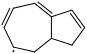

Species has 4 resonance isomer(s)
Library thermo data for species pdt29 matches the estimate from group additivity.

Library thermo data:
H298 = 64.66 kcal/mol
S298 = 90.96 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 58.627 kcal/mol
S298 = 37.72 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 6.033 kcal/mol
Difference S298 = 53.24 cal/mol*K

pdt30


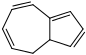

Species has 1 resonance isomer(s)
Library thermo data for species pdt30 matches the estimate from group additivity.

Library thermo data:
H298 = 68.39 kcal/mol
S298 = 88.24 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 54.1 kcal/mol
S298 = 30.01 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 14.29 kcal/mol
Difference S298 = 58.23 cal/mol*K

pdt31


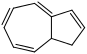

Species has 1 resonance isomer(s)
Library thermo data for species pdt31 matches the estimate from group additivity.

Library thermo data:
H298 = 65.83 kcal/mol
S298 = 87.99 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 54.1 kcal/mol
S298 = 30.01 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 11.73 kcal/mol
Difference S298 = 57.98 cal/mol*K

pdt32


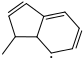

Species has 4 resonance isomer(s)
Library thermo data for species pdt32 matches the estimate from group additivity.

Library thermo data:
H298 = 62.33 kcal/mol
S298 = 91.53 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 56.847 kcal/mol
S298 = 33.3168305179 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 5.483 kcal/mol
Difference S298 = 58.2131694821 cal/mol*K

pdt35


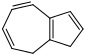

Species has 1 resonance isomer(s)
Library thermo data for species pdt35 matches the estimate from group additivity.

Library thermo data:
H298 = 65.78 kcal/mol
S298 = 88.09 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 57.66 kcal/mol
S298 = 33.49 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 8.12 kcal/mol
Difference S298 = 54.6 cal/mol*K

pdt37


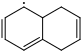

Species has 3 resonance isomer(s)
Library thermo data for species pdt37 matches the estimate from group additivity.

Library thermo data:
H298 = 64.94 kcal/mol
S298 = 89.18 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 62.747 kcal/mol
S298 = 40.27 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 2.193 kcal/mol
Difference S298 = 48.91 cal/mol*K

pdt38


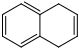

Species has 3 resonance isomer(s)
Library thermo data for species pdt38 matches the estimate from group additivity.

Library thermo data:
H298 = 35.66 kcal/mol
S298 = 86.59 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 32.82 kcal/mol
S298 = 50.68 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 2.84 kcal/mol
Difference S298 = 35.91 cal/mol*K

INDENE


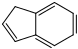

Species has 3 resonance isomer(s)
Library thermo data for species INDENE matches the estimate from group additivity.

Library thermo data:
H298 = 40.49 kcal/mol
S298 = 79.82 cal/mol*K

Original estimated thermo data:
Polycyclic groups: indene
H298 = 37.58 kcal/mol
S298 = 80.06 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 2.91 kcal/mol
Difference S298 = -0.24 cal/mol*K

pdt57


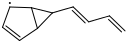

Species has 1 resonance isomer(s)
Library thermo data for species pdt57 does not match the estimate from group additivity

Library thermo data:
H298 = 100.54 kcal/mol
S298 = 95.99 cal/mol*K

Estimated thermo data:
Polycyclic groups: product1
H298 = 99.9441666667 kcal/mol
S298 = 110.740363468 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 0.595833333333 kcal/mol
Difference S298 = -14.7503634677 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 66.167 kcal/mol
S298 = 34.82 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 34.373 kcal/mol
Difference S298 = 61.17 cal/mol*K

2HINDENE


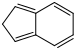

Species has 1 resonance isomer(s)
Library thermo data for species 2HINDENE matches the estimate from group additivity.

Library thermo data:
H298 = 62.6 kcal/mol
S298 = 79.2 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 63.21 kcal/mol
S298 = 20.32 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = -0.61 kcal/mol
Difference S298 = 58.88 cal/mol*K

biring1


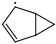

Species has 1 resonance isomer(s)
Library thermo data for species biring1 does not match the estimate from group additivity

Library thermo data:
H298 = 69.9 kcal/mol
S298 = 71.66 cal/mol*K

Estimated thermo data:
Polycyclic groups: product1
H298 = 68.0841666667 kcal/mol
S298 = 83.5103634677 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 1.81583333333 kcal/mol
Difference S298 = -11.8503634677 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 34.307 kcal/mol
S298 = 7.59 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 35.593 kcal/mol
Difference S298 = 64.07 cal/mol*K

prod1


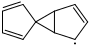

Species has 1 resonance isomer(s)
Library thermo data for species prod1 does not match the estimate from group additivity

Library thermo data:
H298 = 110.21 kcal/mol
S298 = 87.24 cal/mol*K

Estimated thermo data:
Polycyclic groups: product1
H298 = 105.434166667 kcal/mol
S298 = 68.0703634677 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = 4.77583333333 kcal/mol
Difference S298 = 19.1696365323 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 71.657 kcal/mol
S298 = -7.85 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 38.553 kcal/mol
Difference S298 = 95.09 cal/mol*K

prod2


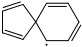

Species has 2 resonance isomer(s)
Library thermo data for species prod2 matches the estimate from group additivity.

Library thermo data:
H298 = 96.34 kcal/mol
S298 = 88.71 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 85.207 kcal/mol
S298 = 31.63 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 11.133 kcal/mol
Difference S298 = 57.08 cal/mol*K

prod4


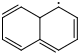

Species has 3 resonance isomer(s)
Library thermo data for species prod4 matches the estimate from group additivity.

Library thermo data:
H298 = 81.64 kcal/mol
S298 = 86.42 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 83.597 kcal/mol
S298 = 30.75 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = -1.957 kcal/mol
Difference S298 = 55.67 cal/mol*K

naphthalene


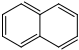

Species has 2 resonance isomer(s)
Library thermo data for species naphthalene matches the estimate from group additivity.

Library thermo data:
H298 = 36.0 kcal/mol
S298 = 79.49 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 36.0 kcal/mol
S298 = 82.24 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 0.0 kcal/mol
Difference S298 = -2.75 cal/mol*K

prod3


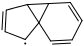

Species has 2 resonance isomer(s)
Library thermo data for species prod3 does not match the estimate from group additivity

Library thermo data:
H298 = 104.32 kcal/mol
S298 = 85.86 cal/mol*K

Estimated thermo data:
Polycyclic groups: product1
H298 = 105.434166667 kcal/mol
S298 = 68.0703634677 cal/mol*K

Comparison of library thermo with estimated thermo
Difference in H298 = -1.11416666667 kcal/mol
Difference S298 = 17.7896365323 cal/mol*K

Original estimated thermo data:
Polycyclic groups: PolycyclicRing
H298 = 71.657 kcal/mol
S298 = -7.85 cal/mol*K

Comparison of library thermo with original estimated thermo
Difference in H298 = 32.663 kcal/mol
Difference S298 = 93.71 cal/mol*K



In [7]:
# Test that the new group additivity values can estimate the old library ones exactly.

for libraryName in thermoLibraries:
    thermoLibrary = database.thermo.libraries[libraryName]
    for label, entry in thermoLibrary.entries.iteritems():
        molecule = entry.item
        libraryThermoData = entry.data

        if molecule.getAllPolycyclicVertices():
            species = Species(molecule=[molecule])
            species.generateResonanceIsomers()
            print label
            display (species.molecule[0])
            print 'Species has {0} resonance isomer(s)'.format(len(species.molecule))
            thermoDatabase.findCp0andCpInf(species, libraryThermoData)
            
            estimatedThermo = thermoDatabase.getThermoDataFromGroups(species)
            originalEstimatedThermo = thermoDatabase0.getThermoDataFromGroups(species)
            if libraryThermoData.isIdenticalTo(estimatedThermo):
                print 'Library thermo data for species {0} matches the estimate from group additivity.\n'.format(label)
                
                print 'Library thermo data:' 
                displayThermo(libraryThermoData)
                print  ''   
                
                print 'Original estimated thermo data:'                
                polycyclicGroupTokens = returnPolycyclicGroupStrings(originalEstimatedThermo.comment)
                print 'Polycyclic groups: {0}'.format(' '.join(polycyclicGroupTokens))
                displayThermo(originalEstimatedThermo)
                print ''
                
                print 'Comparison of library thermo with original estimated thermo'
                compareThermoData(libraryThermoData,originalEstimatedThermo)
                print ''
            else:
                print 'Library thermo data for species {0} does not match the estimate from group additivity\n'.format(label)
                
                print 'Library thermo data:' 
                displayThermo(libraryThermoData)
                print  ''                
                
                print 'Estimated thermo data:'                 
                polycyclicGroupTokens = returnPolycyclicGroupStrings(estimatedThermo.comment)
                print 'Polycyclic groups: {0}'.format(' '.join(polycyclicGroupTokens))
                displayThermo(estimatedThermo)
                print ''
                
                print 'Comparison of library thermo with estimated thermo'
                compareThermoData(libraryThermoData,estimatedThermo)
                print ''
                
                print 'Original estimated thermo data:'                
                polycyclicGroupTokens = returnPolycyclicGroupStrings(originalEstimatedThermo.comment)
                print 'Polycyclic groups: {0}'.format(' '.join(polycyclicGroupTokens))
                displayThermo(originalEstimatedThermo)
                print ''
                
                print 'Comparison of library thermo with original estimated thermo'
                compareThermoData(libraryThermoData,originalEstimatedThermo)
                print ''
            print '======================='

## Check if a molecule descends the tree properly

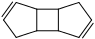

product3


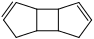

product3


In [8]:
# pdt7 debug
m = Molecule(SMILES='[CH]1C=CC2C1C1C=CCC21')
s = Species(molecule=[m])
s.generateResonanceIsomers()
for isomer in s.molecule:
    isomer.saturate()
    display(isomer)
    print thermoDatabase.groups['polycyclic'].descendTree(isomer,{},None)